In [59]:
from sklearn.svm import SVR
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np

from neo_ls_svm import NeoLSSVM

from utils.encoding import dummie2multilabel


import matplotlib.pyplot as plt
import seaborn as sns

# Utils

In [60]:
def calculate_metrics(y_true, y_pred):
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    # Calculate recall
    recall = recall_score(y_true, y_pred)
    
    # Calculate F1 score
    f1 = f1_score(y_true, y_pred)
    
    # Calculate sensitivity (True Positive Rate)
    cm = confusion_matrix(y_true, y_pred)
    sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0])

    print("Accuracy:", accuracy)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Sensitivity:", sensitivity)
        
    return accuracy, recall, f1, sensitivity


# Load

In [61]:
# prefix = 'denoised'
# prefix = 'noise_denoised'
prefix = 'not_denoised'
# prefix = 'noised'

# feature_selected = False
feature_selected = True

if not feature_selected :
    prefix += '_no'

In [62]:
normalize = False
# normalize = True

In [63]:
# scale = False
scale = True

In [64]:
df_train = pd.read_csv(f'Feature Selected\{prefix}_feature_selected_train.csv')
df_test = pd.read_csv(f'Feature Selected\{prefix}_feature_selected_test.csv')
df_test

,0,1,2,3,4,5,6,7,8,9,Final Label
0,29.034710,8.580418,8.831522,1.994063,-7.015921,0.168486,4.592031,-1.109050,-0.404181,-0.174578,NRG
1,53.489368,10.328308,15.724185,1.725268,-2.285212,1.412913,6.644622,-1.104063,0.212181,0.790209,NRG
2,45.067323,-4.047772,12.242600,6.725836,29.090534,3.564588,3.379654,-0.345151,0.666457,5.163395,NRG
3,743.222568,222.525232,167.078419,-232.652200,-150.665711,-8.764334,115.877014,-17.753041,9.495812,-10.514331,NRG
4,258.440136,117.309882,52.884091,-90.316635,-120.787625,-13.511709,53.033926,-7.336741,0.432699,-13.086931,NRG
...,...,...,...,...,...,...,...,...,...,...,...
1535,61.838171,1.845591,13.912421,-0.863617,32.179088,2.013311,7.264385,-0.532421,0.840326,6.010419,RG
1536,83.419072,28.914606,16.369925,-19.693103,-9.699091,-3.560992,16.415947,-1.987333,0.086500,0.460239,RG
1537,50.302494,8.894628,14.641071,2.385126,0.709354,1.398647,6.219732,-0.971427,0.200245,1.194620,RG
1538,19.768276,0.950562,4.787277,4.096940,9.298824,0.976726,2.997964,-0.831851,-0.303454,1.985396,RG


In [65]:
df_train.loc[df_train['Final Label'] == 'RG', 'Final Label'] = 1 
df_train.loc[df_train['Final Label'] == 'NRG', 'Final Label'] = 0

df_test.loc[df_test['Final Label'] == 'RG', 'Final Label'] = 1
df_test.loc[df_test['Final Label'] == 'NRG', 'Final Label'] = 0

df_train['Final Label'].value_counts()

Final Label
0    2000
1    2000
Name: count, dtype: int64

# Split attribute and label

In [66]:
X_train = df_train.drop(columns=['Final Label'])
y_train = df_train['Final Label'].astype(int)

X_test = df_test.drop(columns=['Final Label'])
y_test = df_test['Final Label'].astype(int)

In [67]:
y_test

0       0
1       0
2       0
3       0
4       0
       ..
1535    1
1536    1
1537    1
1538    1
1539    1
Name: Final Label, Length: 1540, dtype: int32

# Normalize

In [68]:
normalizer = Normalizer()

if normalize :
    X_train = normalizer.fit_transform(X_train)
    X_test = normalizer.transform(X_test)

# Scaler

In [69]:
# Initialize MinMaxScaler
# scaler = MinMaxScaler()
scaler = StandardScaler()

if scale :
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

# Result List

In [70]:
result_list = []

# LS-SVM

In [71]:
model = NeoLSSVM(estimator_type="classifier").fit(X_train, y_train)

In [72]:
y_pred = model.predict(X_test)
y_pred

# Calculate metrics
accuracy, recall, f1, sensitivity = calculate_metrics(y_test, y_pred)

# Append results to DataFrame
result_list.append(
    {
        'Method': 'NeoSVM',
        'Accuracy': accuracy,
        'Recall': recall,
        'F1 Score': f1, 
        'Sensitivity': sensitivity
})

result_list

Accuracy: 0.5987012987012987
Recall: 0.5935064935064935
F1 Score: 0.5966057441253264
Sensitivity: 0.5935064935064935


[{'Method': 'NeoSVM',
  'Accuracy': 0.5987012987012987,
  'Recall': 0.5935064935064935,
  'F1 Score': 0.5966057441253264,
  'Sensitivity': 0.5935064935064935}]

# SVC Scikit

In [73]:
# Define kernel types
kernels = ['linear', 'rbf', 'poly', 'sigmoid']

# Initialize DataFrame to store results

# Iterate through different kernel types
for kernel in kernels:
    # Initialize SVC classifier with current kernel
    clf = SVC(kernel=kernel)
    
    # Train the classifier
    clf.fit(X_train, y_train)
    
    # Make predictions
    y_pred = clf.predict(X_test)  # Assuming X_train is also used for evaluation
    
    # Calculate metrics
    accuracy, recall, f1, sensitivity = calculate_metrics(y_test, y_pred)
    
    result_list.append(
        {
            'Method': 'SVM ' + kernel, 
            'Accuracy': accuracy,
            'Recall': recall,
            'F1 Score': f1, 
            'Sensitivity': sensitivity
    })

Accuracy: 0.5688311688311688
Recall: 0.6532467532467533
F1 Score: 0.6023952095808384
Sensitivity: 0.6532467532467533
Accuracy: 0.5597402597402598
Recall: 0.5363636363636364
F1 Score: 0.5492021276595744
Sensitivity: 0.5363636363636364
Accuracy: 0.5025974025974026
Recall: 0.03506493506493506
F1 Score: 0.06585365853658537
Sensitivity: 0.03506493506493506
Accuracy: 0.5110389610389611
Recall: 0.5454545454545454
F1 Score: 0.527306967984934
Sensitivity: 0.5454545454545454


# KNN

In [74]:
neighbors = [10, 100, 500]

for neighbor in neighbors:
    knn = KNeighborsClassifier(n_neighbors=neighbor)
    
    # Train the classifier
    if normalize or scale :
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)  
    else :
        knn.fit(X_train.values, y_train)
        y_pred = knn.predict(X_test.values)  
    
    # Calculate metrics
    accuracy, recall, f1, sensitivity = calculate_metrics(y_test, y_pred)
    
    # Append results to DataFrame
    result_list.append(
        {
            'Method': f'KNN {neighbor} neighbor', 
            'Accuracy': accuracy,
            'Recall': recall,
            'F1 Score': f1, 
            'Sensitivity': sensitivity
    })


Accuracy: 0.5396103896103897
Recall: 0.43116883116883115
F1 Score: 0.48361252731245447
Sensitivity: 0.43116883116883115
Accuracy: 0.5694805194805195
Recall: 0.5103896103896104
F1 Score: 0.5424430641821946
Sensitivity: 0.5103896103896104
Accuracy: 0.5402597402597402
Recall: 0.522077922077922
F1 Score: 0.5317460317460317
Sensitivity: 0.522077922077922


# Result

In [75]:
results_df = pd.DataFrame(result_list,columns=['Method', 'Accuracy', 'Recall', 'F1 Score', 'Sensitivity'])
results_df.to_csv('temp_result_machine_learning.csv')
results_df

,Method,Accuracy,Recall,F1 Score,Sensitivity
0,NeoSVM,0.598701,0.593506,0.596606,0.593506
1,SVM linear,0.568831,0.653247,0.602395,0.653247
2,SVM rbf,0.559740,0.536364,0.549202,0.536364
3,SVM poly,0.502597,0.035065,0.065854,0.035065
4,SVM sigmoid,0.511039,0.545455,0.527307,0.545455
5,KNN 10 neighbor,0.539610,0.431169,0.483613,0.431169
6,KNN 100 neighbor,0.569481,0.510390,0.542443,0.510390
7,KNN 500 neighbor,0.540260,0.522078,0.531746,0.522078


# Visualize result

In [76]:
all_results_df = pd.read_excel('Hasil Eksperimen.xlsx')
all_results_df

,Model,Dataset,Feature Selected,Normalize,Standardize,Accuracy,Recall,F1,Sensitivity
0,NeoSVM,not denoised,False,False,False,0.665584,0.642857,0.657807,0.642857
1,SVM linear,not denoised,False,False,False,0.612338,0.571429,0.595802,0.571429
2,SVM rbf,not denoised,False,False,False,0.564935,0.640260,0.595411,0.640260
3,SVM poly,not denoised,False,False,False,0.559091,0.789610,0.641689,0.789610
4,SVM sigmoid,not denoised,False,False,False,0.524026,0.511688,0.518080,0.511688
...,...,...,...,...,...,...,...,...,...
139,SVM poly,noise denoise,True,False,True,0.607143,0.761039,0.659539,0.761039
140,SVM sigmoid,noise denoise,True,False,True,0.549351,0.580519,0.562972,0.580519
141,KNN 10 neighbor,noise denoise,True,False,True,0.640260,0.553247,0.605974,0.553247
142,KNN 100 neighbor,noise denoise,True,False,True,0.636364,0.648052,0.640565,0.648052


In [77]:
def plot_metrics_result(df):
    # Plot
    plt.figure(figsize=(10, 6))
    bar_width = 0.2
    index = range(len(df))

    plt.bar(index, df['Accuracy'], bar_width, label='Accuracy')
    plt.bar([i + bar_width for i in index], df['Recall'], bar_width, label='Recall')
    plt.bar([i + 2*bar_width for i in index], df['F1'], bar_width, label='F1 Score')
    # plt.bar([i + 3*bar_width for i in index], df['Sensitivity'], bar_width, label='Sensitivity')

    plt.xlabel('Model')
    plt.ylabel('Metrics')
    plt.title('Performance Metrics by Model')
    plt.xticks([i + 1.5*bar_width for i in index], df['Model'], rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [78]:
def plot_accross_dataset_result(df):
    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Model', y='Accuracy', hue='Dataset', data=df)
    plt.title('Accuracy Score Across Datasets Grouped by Model')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.legend(title='Dataset')
    plt.tight_layout()
    plt.show()

In [17]:
# plot_df = all_results_df[(all_results_df['Dataset'] == 'noise denoise') & (all_results_df['Feature Selected'] == True) & (all_results_df['Normalize'] == False) & (all_results_df['Standardize'] == True)]
# plot_df = all_results_df[(all_results_df['Dataset'] == 'not denoise') & (all_results_df['Feature Selected'] == True) & (all_results_df['Normalize'] == False) & (all_results_df['Standardize'] == True)]
plot_df = all_results_df[(all_results_df['Feature Selected'] == True) & (all_results_df['Normalize'] == False) & (all_results_df['Standardize'] == True)]
plot_df

,Model,Dataset,Feature Selected,Normalize,Standardize,Accuracy,Recall,F1,Sensitivity
136,NeoSVM,noise denoise,True,False,True,0.677273,0.702597,0.685244,0.702597
137,SVM linear,noise denoise,True,False,True,0.624026,0.698701,0.650151,0.698701
138,SVM rbf,noise denoise,True,False,True,0.665584,0.754545,0.692904,0.754545
139,SVM poly,noise denoise,True,False,True,0.607143,0.761039,0.659539,0.761039
140,SVM sigmoid,noise denoise,True,False,True,0.549351,0.580519,0.562972,0.580519
141,KNN 10 neighbor,noise denoise,True,False,True,0.640260,0.553247,0.605974,0.553247
142,KNN 100 neighbor,noise denoise,True,False,True,0.636364,0.648052,0.640565,0.648052
143,KNN 500 neighbor,noise denoise,True,False,True,0.596753,0.631169,0.610169,0.631169


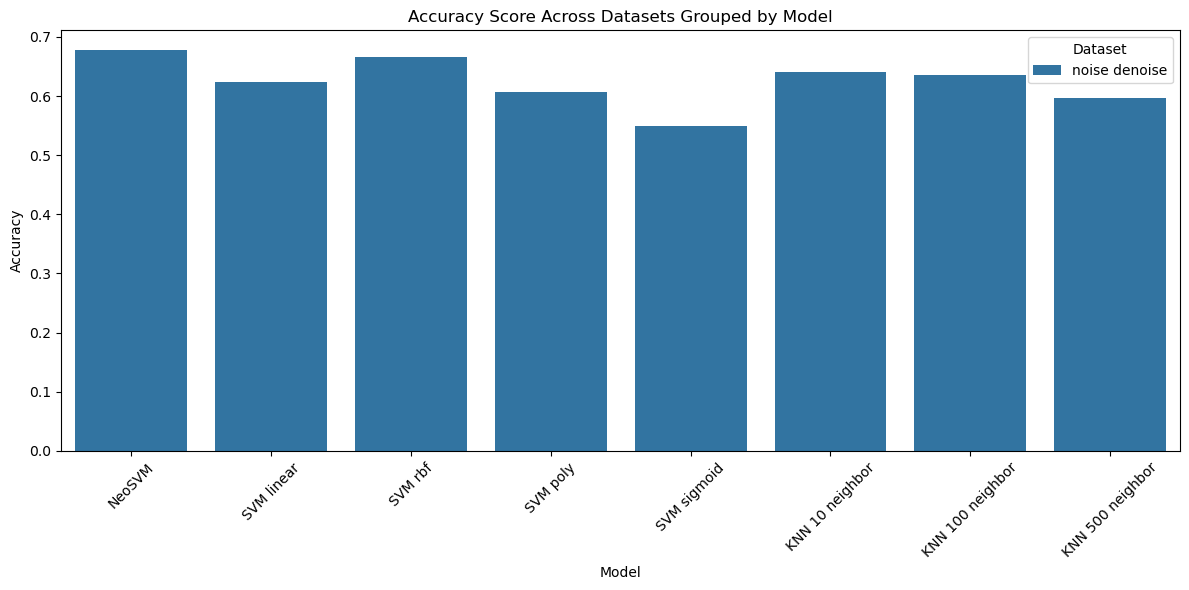

In [79]:
plot_accross_dataset_result(plot_df)

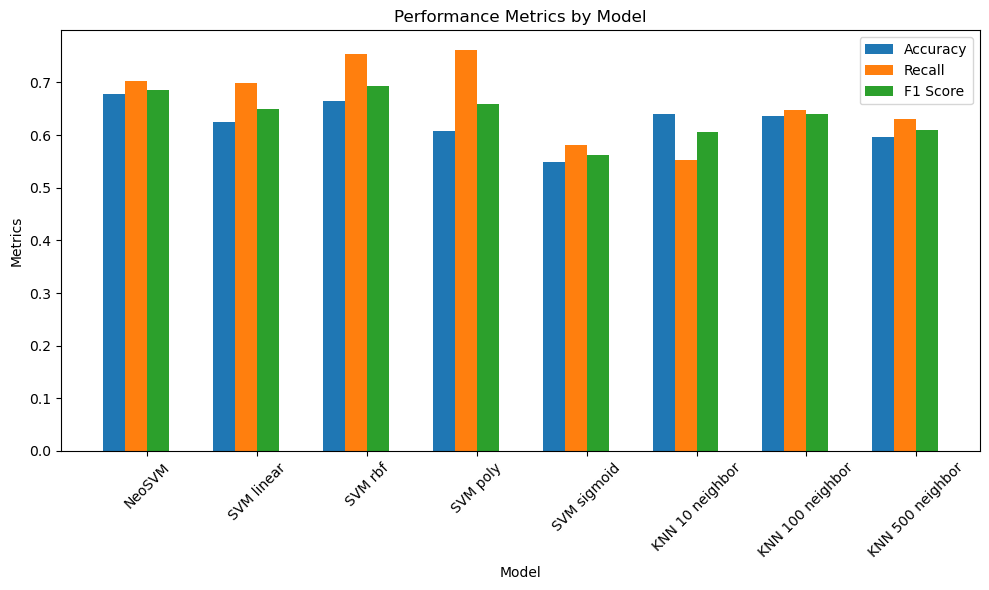

In [18]:
plot_metrics_result(plot_df)